# Train new models using new dataset (1500 compounds)

In [20]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from pandas import DataFrame
from numpy import ndarray
from typing import Union, Any, Dict, Tuple, List

# Local modules
from mrp7pred.utils import (
    DATA, 
    OUTPUT,
    ensure_folder,
    get_current_time,
    plot_roc_auc
)
from mrp7pred.mrp7pred import MRP7Pred
from mrp7pred.grid import grid, grid_light, grid_light_imbalance
from mrp7pred.scoring import get_scoring

ALL_FEATURIZED = "../data/all_compounds_828_features.csv"
MANUAL = "../mrp7pred/feats/all_features_man/full_features_828_20210105-013717.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Load data and get basic statistics

In [2]:
df = pd.read_csv(ALL_FEATURIZED, index_col=0)
df.head()

,name,label,smiles,FractionCSP3,HeavyAtomCount,HeavyAtomMolWt,NHOHCount,NOCount,RingCount,NumAliphaticCarbocycles,...,ATSe7,ATSe8,ATSp1,ATSp2,ATSp3,ATSp4,ATSp5,ATSp6,ATSp7,ATSp8
0,paclitaxel,1,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,...,5.327,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748
1,vincristine,1,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,...,5.285,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,...,4.247,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888
3,E217bG,1,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,...,3.890,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258
4,gemcitabine,1,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,...,2.614,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860


In [3]:
# Check null values
any(df["smiles"].isna())

False

In [4]:
# Check duplicates
len(df["smiles"].values.tolist()) == len(set(df["smiles"].values.tolist()))

False

In [5]:
# Remove duplciates
df_unique = df.drop_duplicates(subset=["smiles"])

In [6]:
# Check again
len(df_unique["smiles"].values.tolist()) == len(set(df_unique["smiles"].values.tolist()))

True

In [7]:
len(df_unique["smiles"].values.tolist()), len(set(df_unique["smiles"].values.tolist()))

(1230, 1230)

In [8]:
df = df_unique.reset_index()

In [9]:
# Check positive / negative
num_1 = len(df[df["label"]==1])
num_0 = len(df[df["label"]==0])
num_1, num_0, round(num_1/num_0, 3)

(129, 1101, 0.117)

In [10]:
df = df.set_index("index")

In [11]:
df.head()

,name,label,smiles,FractionCSP3,HeavyAtomCount,HeavyAtomMolWt,NHOHCount,NOCount,RingCount,NumAliphaticCarbocycles,...,ATSe7,ATSe8,ATSp1,ATSp2,ATSp3,ATSp4,ATSp5,ATSp6,ATSp7,ATSp8
index,,,,,,,,,,,,,,,,,,,,,
0,paclitaxel,1,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,...,5.327,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748
1,vincristine,1,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,...,5.285,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,...,4.247,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888
3,E217bG,1,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,...,3.890,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258
4,gemcitabine,1,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,...,2.614,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860


Spliting training and test data ... Done!
train_1: 106; train_0: 878; test_1: 23; test_0: 223
Start training ... Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best model saved to: ../output/model/best_model_20210112-032455.pkl
Best score: 0.9085258468869781
Done!
Best model:
Pipeline(steps=[('sclr', Normalizer()),
                ('clf',
                 RandomForestClassifier(class_weight={0: 0.01, 1: 0.99},
                                        n_estimators=1000))])
Evaluate model on test data ... Done! Score: 0.9349593495934959
Getting full score set ... Done!
stats
tp: 9.0
fp: 2.0
tn: 221.0
fn: 14.0
score
roc_auc: 0.7615519594462857
accuracy: 0.9349593495934959
precision: 0.8181818181818182
recall: 0.391304347826087
specificity: 0.9910313901345291
mcc: 0.538556126157315
Plotting ROC for test data ... 

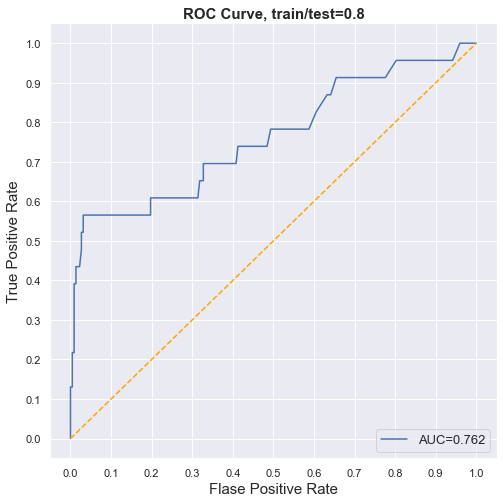

Done!


In [12]:
m7p = MRP7Pred(train_new=True)
m7p.run_train(df, grid=grid_light, train_test_ratio=0.8, featurized=True)

## Try manual dataset only

In [16]:
# 1. load data
df = pd.read_csv(MANUAL, index_col=0)
df.head()

,name,label,smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,...,pychem_ATSe7,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8
0,paclitaxel,1,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,...,5.327,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748
1,vincristine,1,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,...,5.285,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,...,4.247,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888
3,E217bG,1,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,...,3.890,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258
4,gemcitabine,1,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,...,2.614,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860


In [17]:
# Check null values
any(df["smiles"].isna())

False

In [18]:
# Check duplicates
len(df["smiles"].values.tolist()) == len(set(df["smiles"].values.tolist()))

True

In [19]:
# Check positive / negative
num_1 = len(df[df["label"]==1])
num_0 = len(df[df["label"]==0])
num_1, num_0, round(num_1/num_0, 3)

(54, 63, 0.857)

Spliting training and test data ... Done!
train_1: 40; train_0: 53; test_1: 14; test_0: 10
Start training ... Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best model saved to: ../output/model/best_model_20210112-110103.pkl
Best score: 0.7853801169590644
Done!
Best model:
Pipeline(steps=[('sclr', Normalizer()),
                ('clf', RandomForestClassifier(n_estimators=1000))])
Evaluate model on test data ... Done! Score: 0.7083333333333334
Getting full score set ... Done!
stats
tp: 9.0
fp: 2.0
tn: 8.0
fn: 5.0
score
roc_auc: 0.8571428571428572
accuracy: 0.7083333333333334
precision: 0.8181818181818182
recall: 0.6428571428571429
specificity: 0.8
mcc: 0.4381871654989361
Plotting ROC for test data ... 

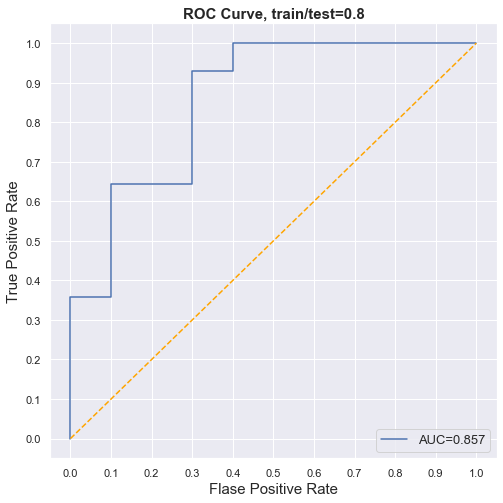

Done!


In [24]:
m7p = MRP7Pred(train_new=True)
m7p.auto_train_test(df, grid=grid_light_balance, train_test_ratio=0.8, featurized=True)

# 2021-3-8 Re-train using manual data with new pipeline

The new pipeline has integrated feature selection process

## 1. Load featurized data

In [54]:
import pandas as pd

df_man_feats = pd.read_csv("./man_full_features_828_20210115-085233.csv", index_col=0)
df_man_feats = df_man_feats.rename(columns={"std_smiles":"smiles"})
# append label
df_man_pos = pd.read_csv("../data/manual/positive.csv")
df_man_neg = pd.read_csv("../data/manual/negative.csv")
pos_l = df_man_pos["compound_name"].values.tolist()
neg_l = df_man_neg["compound_name"].values.tolist()
df_man_feats["label"] = df_man_feats["name"].apply(lambda x: 1 if x in pos_l else 0)
df_man_feats

,name,smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748,1
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799,1
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888,1
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258,1
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CCTA-45,O=C(Nc1cccc(-c2cc(F)cc(F)c2)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.683,2.987,3.254,3.163,3.045,3.063,2.856,2.604,2.351,0
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399,0
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365,0
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412,0


## 2. Training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Remove features with all zeros ... Done!
Selected 665/828 features
Calculating correlation matrix ... Done!
Creating correlation graph ... Done!
Selected 339/828 features
Drop nan ... Done!
Spliting training and test data ... 
Done!
train_1: 38; train_0: 54; test_1: 13; test_0: 10
Start training ... Fitting 5 folds for each of 58 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1949s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.5941s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   45.8s
[Parallel(n_j

Best score: 0.7941520467836257
Done!
Best model:
Pipeline(steps=[('fsel',
                 FeatureSelector(selected_feature_id=array([  7,  18,  25,  30,  34,  37,  47,  51,  61,  62,  68,  72,  73,
        75,  76,  85,  87,  88,  90,  91,  94,  97,  98, 103, 104, 105,
       125, 126, 127, 128, 133, 148, 149, 150, 151, 152, 153, 154, 163,
       164, 165, 174, 175, 186, 192, 193, 194, 228, 246, 259, 263, 276,
       277, 278, 279, 303, 351, 359, 367, 375, 388, 390, 391, 405, 407,
       413, 482, 483, 488, 491, 492, 496, 499, 500, 503, 504, 505...
       642, 643, 644, 645, 647, 648, 649, 661, 662, 663, 664, 669, 671,
       672, 673, 674, 676, 677, 678, 679, 684, 690, 691, 692, 693, 694,
       695, 696, 697, 702, 703, 707, 711, 712, 715, 718, 720, 729, 730,
       731, 732, 733, 734, 735, 736, 745, 746, 752, 753, 756, 757, 761,
       762, 763, 764, 765, 766, 767, 776, 777, 778, 779, 784, 785, 786,
       788, 789, 790, 792, 793, 795, 826]))),
                ('sclr', MinMaxScaler(

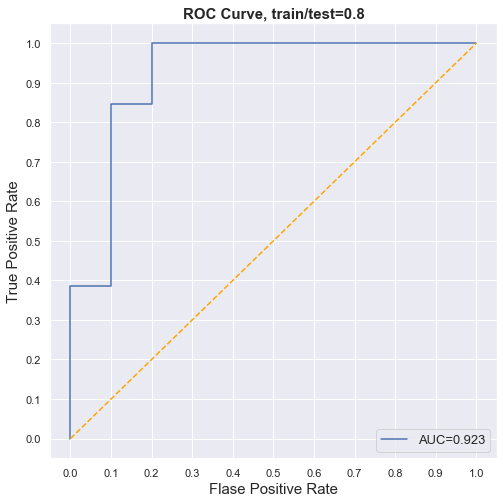

Done!


In [68]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

from mrp7pred.mrp7pred import MRP7Pred
from mrp7pred.grid import grid_light, grid_light_imbalance, grid

m7p = MRP7Pred(train_new = True)
m7p.auto_train_test(
    df = df_man_feats,
    grid = grid_light,
    model_dir = ".",
    feats_dir = ".",
    train_test_ratio = 0.8,
    featurized = True,
    prefix = "man_modulator_115_",
    time_limit=15,
    scoring='precision',
)
clf = m7p.clf_best

## 3. On unknown data

In [23]:
df_unk = pd.read_csv("./featurized_unknown__full_features_828_20210206-132138.csv", index_col=0)
df_unk

,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,rdk_NumAliphaticRings,rdk_NumAromaticCarbocycles,...,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,name,smiles
0,0.250000,33,441.749,3,8,3,0,0,0,2,...,3.424,3.643,3.663,3.678,3.775,3.713,3.438,3.179,Citarinostat,O=C(CCCCCCNC(=O)c1cnc(N(c2ccccc2)c2ccccc2Cl)nc...
1,0.083333,21,298.215,1,8,2,0,0,0,1,...,2.934,3.173,3.062,3.005,2.977,2.858,2.673,2.456,Nitazoxanide,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1
2,0.181818,28,350.276,2,6,5,0,1,1,1,...,3.362,3.707,3.748,3.724,3.779,3.764,3.591,3.219,Galunisertib,Cc1cccc(-c2nn3c(c2-c2ccnc4ccc(C(N)=O)cc24)CCC3)n1
3,0.280000,37,522.218,3,9,4,0,1,1,2,...,3.523,3.851,3.916,3.784,3.701,3.703,3.626,3.474,Ensartinib,CC(Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2)nnc1...
4,0.260870,30,385.269,3,6,5,1,0,1,2,...,3.373,3.663,3.630,3.575,3.582,3.555,3.498,3.300,Anlotinib,COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ccnc2cc1OCC1(N)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.363636,31,422.718,1,7,4,0,1,1,2,...,3.329,3.630,3.658,3.497,3.478,3.485,3.488,3.393,Gefitinib,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
73,0.272727,29,370.259,1,7,3,0,0,0,2,...,3.234,3.502,3.564,3.478,3.522,3.547,3.491,3.318,Erlotinib,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
74,0.240000,35,490.220,2,7,5,0,1,1,2,...,3.526,3.872,3.961,3.905,3.806,3.700,3.569,3.455,FRAX486,CCn1c(=O)c(-c2ccc(Cl)cc2Cl)cc2cnc(Nc3ccc(N4CCN...
75,0.066667,22,304.651,2,5,3,0,0,0,1,...,3.060,3.348,3.372,3.324,3.276,3.192,2.941,2.447,AZD4635,Cc1cc(-c2nnc(N)nc2-c2ccc(F)cc2)cc(Cl)n1


In [69]:
result_df = m7p.predict(
        compound_df = df_unk,
        featurized_df = df_unk,
        prefix = "man_115_",
        out_dir = "."
    )
f"{len(result_df[result_df.pred==1])}/{len(result_df)}"

Start predicting ... Done!
Writing output ... Done! Results saved to: ./man_115_predicted_20210311-233732.csv


'44/77'